In [119]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score,mean_squared_error

Epoch 1/50


/Users/aliabouyahia/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0292 - mean_absolute_error: 0.0932
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0039 - mean_absolute_error: 0.0370
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0035 - mean_absolute_error: 0.0343
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0033 - mean_absolute_error: 0.0348
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0026 - mean_absolute_error: 0.0320
Epoch 6/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0026 - mean_absolute_error: 0.0324
Epoch 7/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0026 - mean_absolute_error: 0.0325
Epoch 8/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0026 - mean_absolute_error: 0.0325
Epoch 9/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0023 - mean_absolute_error: 0.0320
Epoch 10/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0024 - mean_absolute_error: 0.0327
Epoch 11/50
148/148 ━━━━━━━━━━

/Users/aliabouyahia/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


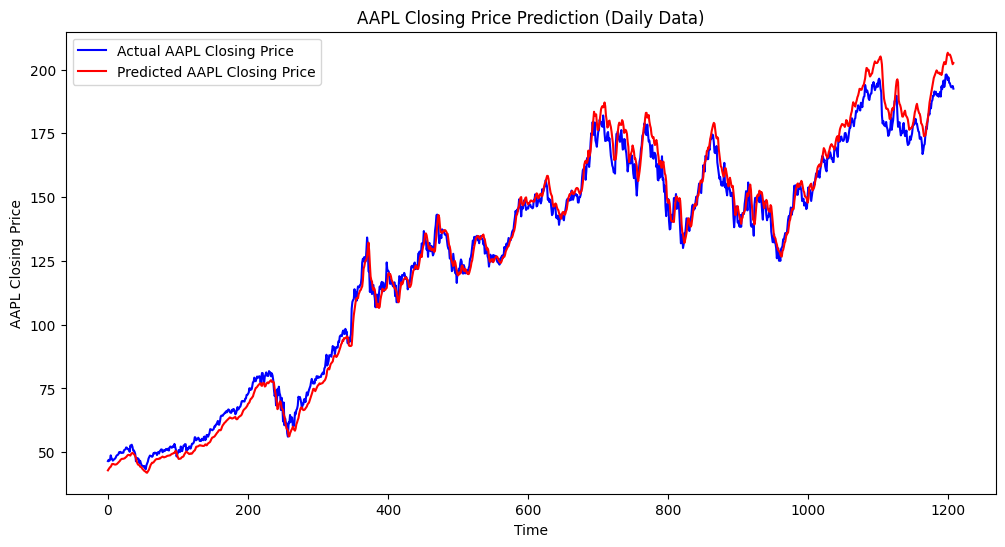

                           Metric  Value
0             Mean Absolute Error   3.86
1         Root Mean Squared Error   4.82
2  Mean Absolute Percentage Error  3.35%
3                        R2 Score   0.99


In [120]:
# Data Loading
data = pd.read_csv('/Users/aliabouyahia/Downloads/Data/AAPL-Daily.csv')

# Check for NaN and infinite values
data.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values with NaN
data.dropna(inplace=True)  # Drop rows with NaN values

# Data Splitting
train = data[0:int(len(data) * 0.80)]
test = data[int(len(data) * 0.80):]

# Features to be used (Open, High, Low)
features = ['Open', 'High', 'Low']

# Scaling the Data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[features])
test_scaled = scaler.transform(test[features])

# Scaling the Close price separately
close_scaler = MinMaxScaler(feature_range=(0, 1))
train_close = close_scaler.fit_transform(train[['Close']])
test_close = close_scaler.transform(test[['Close']])

# Preparing the Training Data
x_train = []
y_train = []

# Here we're using a window size of 100 for sequence creation
for i in range(100, len(train_scaled)):
    x_train.append(train_scaled[i-100:i, :])  # Use 100 days of data for each input
    y_train.append(train_close[i, 0])         # Predict the Close price

x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train to 3D array for LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], len(features)))

# Model Construction
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(x_train.shape[1], len(features))))  # Adjusted input_shape
model.add(Dropout(0.3)) #Droppout allows us to tackle overfitting issues, adjust this value can lead to slightly improved results
model.add(Dense(units=1))

# Model Compilation
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Model Training
model.fit(x_train, y_train, epochs=50, batch_size=32)

# Preparing Testing Data
total_data = pd.concat((train[features], test[features]), axis=0)
inputs = total_data[len(total_data) - len(test) - 100:].values
inputs = scaler.transform(inputs)

x_test = []
Actual_Values = []

for i in range(100, len(inputs)):
    x_test.append(inputs[i-100:i, :])  # Use 100 days of data for each input
    Actual_Values.append(test_close[i-100, 0])  # Predict the Close price

x_test, Actual_Values = np.array(x_test), np.array(Actual_Values)

# Reshaping in 3D array for LSTM model 
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], len(features)))

# Closing Prices forecast
Predicted_Values = model.predict(x_test)

# Inverse scaling the predictions and actual values and plotting 
Predicted_Values = close_scaler.inverse_transform(Predicted_Values)
Actual_Values = close_scaler.inverse_transform(Actual_Values.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(Actual_Values, color='blue', label='Actual AAPL Closing Price')
plt.plot(Predicted_Values, color='red', label='Predicted AAPL Closing Price')
plt.title('AAPL Closing Price Prediction (Daily Data)')
plt.xlabel('Time')
plt.ylabel('AAPL Closing Price')
plt.legend()
plt.show()

# Metrics Evaluation
mae = mean_absolute_error(Actual_Values, Predicted_Values)
mape = mean_absolute_percentage_error(Actual_Values, Predicted_Values)
r2_Score = r2_score(Actual_Values, Predicted_Values)
rmse =np.sqrt(mean_squared_error(Actual_Values,Predicted_Values))

metrics = {
    'Metric': ['Mean Absolute Error', 'Root Mean Squared Error', 'Mean Absolute Percentage Error', 'R2 Score'],
    'Value': [f'{mae:.2f}', f'{rmse:.2f}', f'{(mape*100):.2f}%', f'{r2_Score:.2f}']
}
metrics_Table = pd.DataFrame(metrics)
print(metrics_Table)


Epoch 1/50


/Users/aliabouyahia/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0841 - mean_absolute_error: 0.1968
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0139 - mean_absolute_error: 0.0691
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0070 - mean_absolute_error: 0.0519
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0065 - mean_absolute_error: 0.0509
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0070 - mean_absolute_error: 0.0535
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0061 - mean_absolute_error: 0.0472
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0057 - mean_absolute_error: 0.0468
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0061 - mean_absolute_error: 0.0464
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0059 - mean_absolute_error: 0.0480
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0057 - mean_absolute_error: 0.0447
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/ste

/Users/aliabouyahia/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


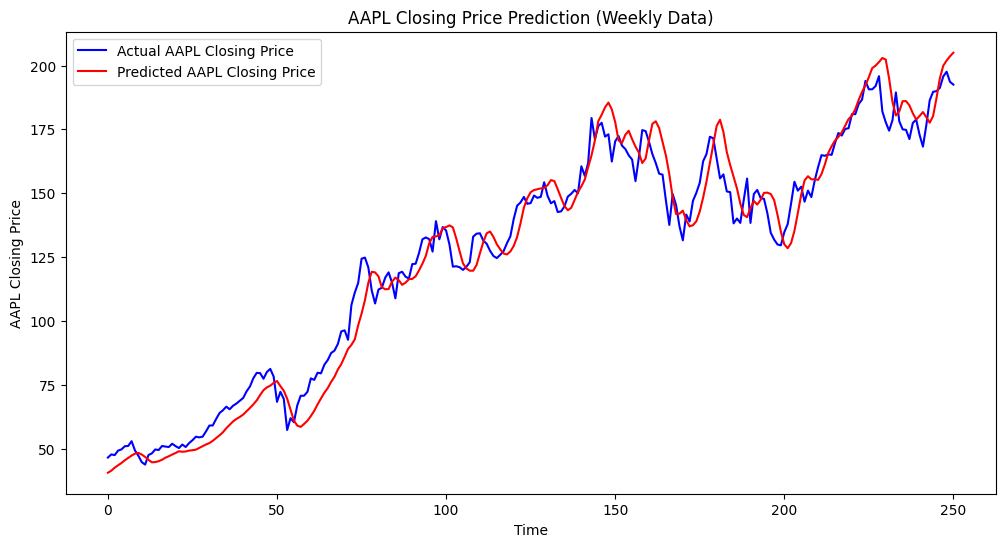

                           Metric  Value
0             Mean Absolute Error   7.11
1         Root Mean Squared Error   8.74
2  Mean Absolute Percentage Error  6.35%
3                        R2 Score   0.96


In [121]:
# Data Loading
data = pd.read_csv('/Users/aliabouyahia/Downloads/Data/AAPL-Weekly.csv')

# Check for NaN and infinite values
data.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values with NaN
data.dropna(inplace=True)  # Drop rows with NaN values

# Data Splitting
train = data[0:int(len(data) * 0.80)]
test = data[int(len(data) * 0.80):]

# Features to be used (Open, High, Low)
features = ['Open', 'High', 'Low']

# Scaling the Data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[features])
test_scaled = scaler.transform(test[features])

# Scaling the Close price separately
close_scaler = MinMaxScaler(feature_range=(0, 1))
train_close = close_scaler.fit_transform(train[['Close']])
test_close = close_scaler.transform(test[['Close']])

# Preparing the Training Data
x_train = []
y_train = []

# Here we're using a window size of 100 for sequence creation
for i in range(100, len(train_scaled)):
    x_train.append(train_scaled[i-100:i, :])  # Use 100 days of data for each input
    y_train.append(train_close[i, 0])         # Predict the Close price

x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train to 3D array for LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], len(features)))

# Model Construction
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(x_train.shape[1], len(features))))  # Adjusted input_shape
model.add(Dropout(0.3)) #Droppout allows us to tackle overfitting issues, adjust this value can lead to slightly improved results
model.add(Dense(units=1))

# Model Compilation
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Model Training
model.fit(x_train, y_train, epochs=50, batch_size=32)

# Preparing Testing Data
total_data = pd.concat((train[features], test[features]), axis=0)
inputs = total_data[len(total_data) - len(test) - 100:].values
inputs = scaler.transform(inputs)

x_test = []
Actual_Values = []

for i in range(100, len(inputs)):
    x_test.append(inputs[i-100:i, :])  # Use 100 days of data for each input
    Actual_Values.append(test_close[i-100, 0])  # Predict the Close price

x_test, Actual_Values = np.array(x_test), np.array(Actual_Values)

# Reshaping in 3D array for LSTM model 
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], len(features)))

# Closing Prices forecast
Predicted_Values = model.predict(x_test)

# Inverse scaling the predictions and actual values and plotting 
Predicted_Values = close_scaler.inverse_transform(Predicted_Values)
Actual_Values = close_scaler.inverse_transform(Actual_Values.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(Actual_Values, color='blue', label='Actual AAPL Closing Price')
plt.plot(Predicted_Values, color='red', label='Predicted AAPL Closing Price')
plt.title('AAPL Closing Price Prediction (Weekly Data)')
plt.xlabel('Time')
plt.ylabel('AAPL Closing Price')
plt.legend()
plt.show()

# Metrics Evaluation
mae = mean_absolute_error(Actual_Values, Predicted_Values)
mape = mean_absolute_percentage_error(Actual_Values, Predicted_Values)
r2_Score = r2_score(Actual_Values, Predicted_Values)
rmse =np.sqrt(mean_squared_error(Actual_Values,Predicted_Values))

metrics = {
    'Metric': ['Mean Absolute Error', 'Root Mean Squared Error', 'Mean Absolute Percentage Error', 'R2 Score'],
    'Value': [f'{mae:.2f}', f'{rmse:.2f}', f'{(mape*100):.2f}%', f'{r2_Score:.2f}']
}
metrics_Table = pd.DataFrame(metrics)
print(metrics_Table)

Epoch 1/50


/Users/aliabouyahia/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0221 - mean_absolute_error: 0.0709
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0043 - mean_absolute_error: 0.0304
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0028 - mean_absolute_error: 0.0265
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0024 - mean_absolute_error: 0.0257
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0023 - mean_absolute_error: 0.0256
Epoch 6/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0020 - mean_absolute_error: 0.0248
Epoch 7/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0029 - mean_absolute_error: 0.0281
Epoch 8/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0024 - mean_absolute_error: 0.0272
Epoch 9/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0023 - mean_absolute_error: 0.0274
Epoch 10/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0026 - mean_absolute_error: 0.0282
Epoch 11/50
148/148 ━━━━━━━━━━

/Users/aliabouyahia/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


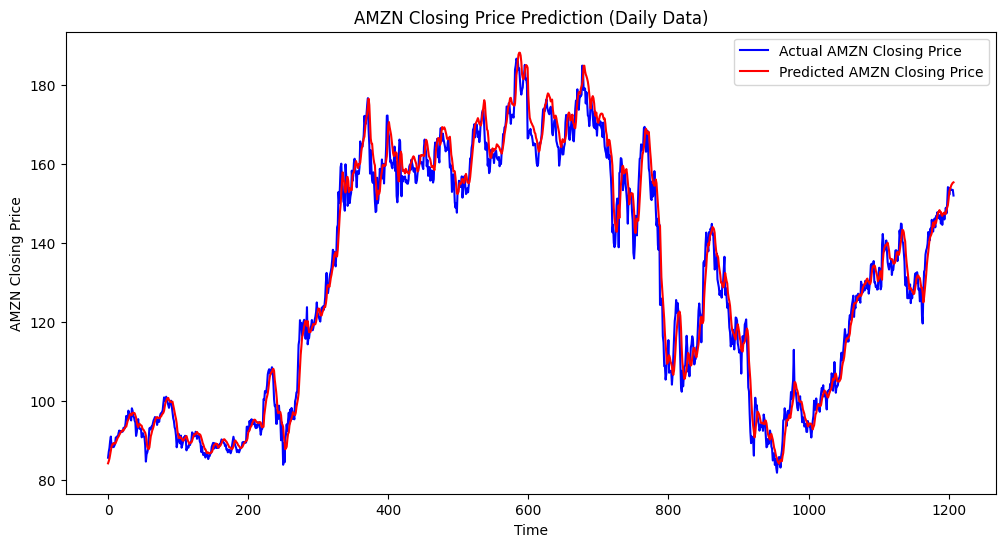

                           Metric  Value
0             Mean Absolute Error   3.10
1         Root Mean Squared Error   4.16
2  Mean Absolute Percentage Error  2.41%
3                        R2 Score   0.98


In [122]:
# Data Loading
data = pd.read_csv('/Users/aliabouyahia/Downloads/Data/AMZN-Daily.csv')

# Check for NaN and infinite values
data.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values with NaN
data.dropna(inplace=True)  # Drop rows with NaN values

# Data Splitting
train = data[0:int(len(data) * 0.80)]
test = data[int(len(data) * 0.80):]

# Features to be used (Open, High, Low)
features = ['Open', 'High', 'Low']

# Scaling the Data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[features])
test_scaled = scaler.transform(test[features])

# Scaling the Close price separately
close_scaler = MinMaxScaler(feature_range=(0, 1))
train_close = close_scaler.fit_transform(train[['Close']])
test_close = close_scaler.transform(test[['Close']])

# Preparing the Training Data
x_train = []
y_train = []

# Here we're using a window size of 100 for sequence creation
for i in range(100, len(train_scaled)):
    x_train.append(train_scaled[i-100:i, :])  # Use 100 days of data for each input
    y_train.append(train_close[i, 0])         # Predict the Close price

x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train to 3D array for LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], len(features)))

# Model Construction
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(x_train.shape[1], len(features))))  # Adjusted input_shape
model.add(Dropout(0.3)) #Droppout allows us to tackle overfitting issues, adjust this value can lead to slightly improved results
model.add(Dense(units=1))

# Model Compilation
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Model Training
model.fit(x_train, y_train, epochs=50, batch_size=32)

# Preparing Testing Data
total_data = pd.concat((train[features], test[features]), axis=0)
inputs = total_data[len(total_data) - len(test) - 100:].values
inputs = scaler.transform(inputs)

x_test = []
Actual_Values = []

for i in range(100, len(inputs)):
    x_test.append(inputs[i-100:i, :])  # Use 100 days of data for each input
    Actual_Values.append(test_close[i-100, 0])  # Predict the Close price

x_test, Actual_Values = np.array(x_test), np.array(Actual_Values)

# Reshaping in 3D array for LSTM model 
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], len(features)))

# Closing Prices forecast
Predicted_Values = model.predict(x_test)

# Inverse scaling the predictions and actual values and plotting 
Predicted_Values = close_scaler.inverse_transform(Predicted_Values)
Actual_Values = close_scaler.inverse_transform(Actual_Values.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(Actual_Values, color='blue', label='Actual AMZN Closing Price')
plt.plot(Predicted_Values, color='red', label='Predicted AMZN Closing Price')
plt.title('AMZN Closing Price Prediction (Daily Data)')
plt.xlabel('Time')
plt.ylabel('AMZN Closing Price')
plt.legend()
plt.show()

# Metrics Evaluation
mae = mean_absolute_error(Actual_Values, Predicted_Values)
mape = mean_absolute_percentage_error(Actual_Values, Predicted_Values)
r2_Score = r2_score(Actual_Values, Predicted_Values)
rmse =np.sqrt(mean_squared_error(Actual_Values,Predicted_Values))

metrics = {
    'Metric': ['Mean Absolute Error', 'Root Mean Squared Error', 'Mean Absolute Percentage Error', 'R2 Score'],
    'Value': [f'{mae:.2f}', f'{rmse:.2f}', f'{(mape*100):.2f}%', f'{r2_Score:.2f}']
}
metrics_Table = pd.DataFrame(metrics)
print(metrics_Table)


Epoch 1/50


/Users/aliabouyahia/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0279 - mean_absolute_error: 0.0895
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0068 - mean_absolute_error: 0.0427
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0043 - mean_absolute_error: 0.0349
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0037 - mean_absolute_error: 0.0280
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0029 - mean_absolute_error: 0.0273
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0021 - mean_absolute_error: 0.0224
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0021 - mean_absolute_error: 0.0225
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0030 - mean_absolute_error: 0.0274
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0021 - mean_absolute_error: 0.0231
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0026 - mean_absolute_error: 0.0276
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/ste

/Users/aliabouyahia/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


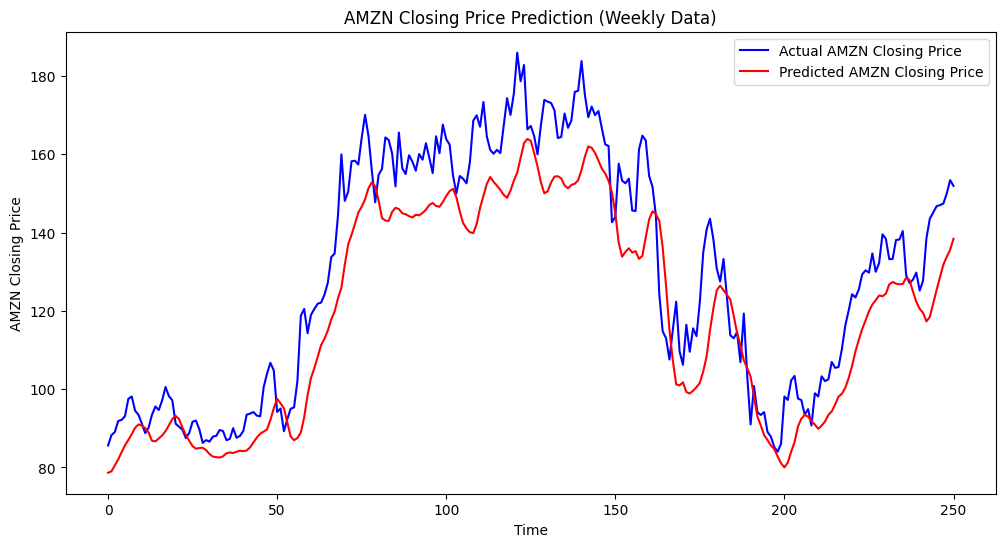

                           Metric  Value
0             Mean Absolute Error  11.53
1         Root Mean Squared Error  13.75
2  Mean Absolute Percentage Error  8.60%
3                        R2 Score   0.79


In [123]:
# Data Loading
data = pd.read_csv('/Users/aliabouyahia/Downloads/Data/AMZN-Weekly.csv')

# Check for NaN and infinite values
data.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values with NaN
data.dropna(inplace=True)  # Drop rows with NaN values

# Data Splitting
train = data[0:int(len(data) * 0.80)]
test = data[int(len(data) * 0.80):]

# Features to be used (Open, High, Low)
features = ['Open', 'High', 'Low']

# Scaling the Data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[features])
test_scaled = scaler.transform(test[features])

# Scaling the Close price separately
close_scaler = MinMaxScaler(feature_range=(0, 1))
train_close = close_scaler.fit_transform(train[['Close']])
test_close = close_scaler.transform(test[['Close']])

# Preparing the Training Data
x_train = []
y_train = []

# Here we're using a window size of 100 for sequence creation
for i in range(100, len(train_scaled)):
    x_train.append(train_scaled[i-100:i, :])  # Use 100 days of data for each input
    y_train.append(train_close[i, 0])         # Predict the Close price

x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train to 3D array for LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], len(features)))

# Model Construction
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(x_train.shape[1], len(features))))  # Adjusted input_shape
model.add(Dropout(0.3)) #Droppout allows us to tackle overfitting issues, adjust this value can lead to slightly improved results
model.add(Dense(units=1))

# Model Compilation
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Model Training
model.fit(x_train, y_train, epochs=50, batch_size=32)

# Preparing Testing Data
total_data = pd.concat((train[features], test[features]), axis=0)
inputs = total_data[len(total_data) - len(test) - 100:].values
inputs = scaler.transform(inputs)

x_test = []
Actual_Values = []

for i in range(100, len(inputs)):
    x_test.append(inputs[i-100:i, :])  # Use 100 days of data for each input
    Actual_Values.append(test_close[i-100, 0])  # Predict the Close price

x_test, Actual_Values = np.array(x_test), np.array(Actual_Values)

# Reshaping in 3D array for LSTM model 
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], len(features)))

# Closing Prices forecast
Predicted_Values = model.predict(x_test)

# Inverse scaling the predictions and actual values and plotting 
Predicted_Values = close_scaler.inverse_transform(Predicted_Values)
Actual_Values = close_scaler.inverse_transform(Actual_Values.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(Actual_Values, color='blue', label='Actual AMZN Closing Price')
plt.plot(Predicted_Values, color='red', label='Predicted AMZN Closing Price')
plt.title('AMZN Closing Price Prediction (Weekly Data)')
plt.xlabel('Time')
plt.ylabel('AMZN Closing Price')
plt.legend()
plt.show()

# Metrics Evaluation
mae = mean_absolute_error(Actual_Values, Predicted_Values)
mape = mean_absolute_percentage_error(Actual_Values, Predicted_Values)
r2_Score = r2_score(Actual_Values, Predicted_Values)
rmse =np.sqrt(mean_squared_error(Actual_Values,Predicted_Values))

metrics = {
    'Metric': ['Mean Absolute Error', 'Root Mean Squared Error', 'Mean Absolute Percentage Error', 'R2 Score'],
    'Value': [f'{mae:.2f}', f'{rmse:.2f}', f'{(mape*100):.2f}%', f'{r2_Score:.2f}']
}
metrics_Table = pd.DataFrame(metrics)
print(metrics_Table)

Epoch 1/50


/Users/aliabouyahia/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0471 - mean_absolute_error: 0.1273
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0050 - mean_absolute_error: 0.0459
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0038 - mean_absolute_error: 0.0407
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0033 - mean_absolute_error: 0.0367
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0030 - mean_absolute_error: 0.0351
Epoch 6/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0025 - mean_absolute_error: 0.0335
Epoch 7/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0022 - mean_absolute_error: 0.0313
Epoch 8/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0023 - mean_absolute_error: 0.0325
Epoch 9/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0021 - mean_absolute_error: 0.0307
Epoch 10/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0025 - mean_absolute_error: 0.0334
Epoch 11/50
148/148 ━━━━━━━━━━

/Users/aliabouyahia/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


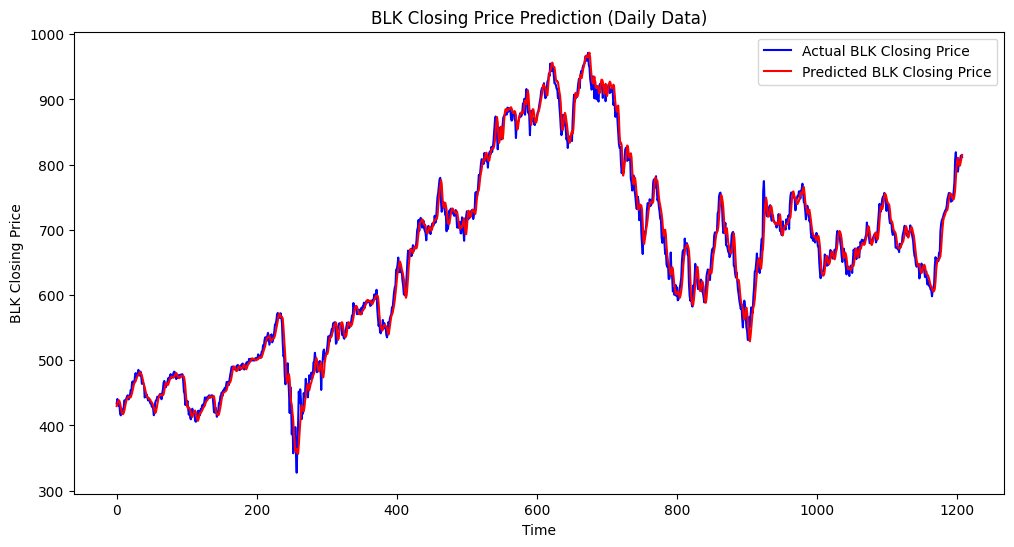

                           Metric  Value
0             Mean Absolute Error  11.56
1         Root Mean Squared Error  15.83
2  Mean Absolute Percentage Error  1.82%
3                        R2 Score   0.99


In [124]:
# Data Loading
data = pd.read_csv('/Users/aliabouyahia/Downloads/Data/BLK-Daily.csv')

# Check for NaN and infinite values
data.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values with NaN
data.dropna(inplace=True)  # Drop rows with NaN values

# Data Splitting
train = data[0:int(len(data) * 0.80)]
test = data[int(len(data) * 0.80):]

# Features to be used (Open, High, Low)
features = ['Open', 'High', 'Low']

# Scaling the Data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[features])
test_scaled = scaler.transform(test[features])

# Scaling the Close price separately
close_scaler = MinMaxScaler(feature_range=(0, 1))
train_close = close_scaler.fit_transform(train[['Close']])
test_close = close_scaler.transform(test[['Close']])

# Preparing the Training Data
x_train = []
y_train = []

# Here we're using a window size of 100 for sequence creation
for i in range(100, len(train_scaled)):
    x_train.append(train_scaled[i-100:i, :])  # Use 100 days of data for each input
    y_train.append(train_close[i, 0])         # Predict the Close price

x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train to 3D array for LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], len(features)))

# Model Construction
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(x_train.shape[1], len(features))))  # Adjusted input_shape
model.add(Dropout(0.3)) #Droppout allows us to tackle overfitting issues, adjust this value can lead to slightly improved results
model.add(Dense(units=1))

# Model Compilation
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Model Training
model.fit(x_train, y_train, epochs=50, batch_size=32)

# Preparing Testing Data
total_data = pd.concat((train[features], test[features]), axis=0)
inputs = total_data[len(total_data) - len(test) - 100:].values
inputs = scaler.transform(inputs)

x_test = []
Actual_Values = []

for i in range(100, len(inputs)):
    x_test.append(inputs[i-100:i, :])  # Use 100 days of data for each input
    Actual_Values.append(test_close[i-100, 0])  # Predict the Close price

x_test, Actual_Values = np.array(x_test), np.array(Actual_Values)

# Reshaping in 3D array for LSTM model 
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], len(features)))

# Closing Prices forecast
Predicted_Values = model.predict(x_test)

# Inverse scaling the predictions and actual values and plotting 
Predicted_Values = close_scaler.inverse_transform(Predicted_Values)
Actual_Values = close_scaler.inverse_transform(Actual_Values.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(Actual_Values, color='blue', label='Actual BLK Closing Price')
plt.plot(Predicted_Values, color='red', label='Predicted BLK Closing Price')
plt.title('BLK Closing Price Prediction (Daily Data)')
plt.xlabel('Time')
plt.ylabel('BLK Closing Price')
plt.legend()
plt.show()

# Metrics Evaluation
mae = mean_absolute_error(Actual_Values, Predicted_Values)
mape = mean_absolute_percentage_error(Actual_Values, Predicted_Values)
r2_Score = r2_score(Actual_Values, Predicted_Values)
rmse =np.sqrt(mean_squared_error(Actual_Values,Predicted_Values))

metrics = {
    'Metric': ['Mean Absolute Error', 'Root Mean Squared Error', 'Mean Absolute Percentage Error', 'R2 Score'],
    'Value': [f'{mae:.2f}', f'{rmse:.2f}', f'{(mape*100):.2f}%', f'{r2_Score:.2f}']
}
metrics_Table = pd.DataFrame(metrics)
print(metrics_Table)


Epoch 1/50


/Users/aliabouyahia/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0540 - mean_absolute_error: 0.1692
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0087 - mean_absolute_error: 0.0661
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0065 - mean_absolute_error: 0.0572
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0049 - mean_absolute_error: 0.0477
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0056 - mean_absolute_error: 0.0506
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0051 - mean_absolute_error: 0.0510
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0047 - mean_absolute_error: 0.0460
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0050 - mean_absolute_error: 0.0496
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0051 - mean_absolute_error: 0.0489
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0036 - mean_absolute_error: 0.0426
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/ste

/Users/aliabouyahia/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


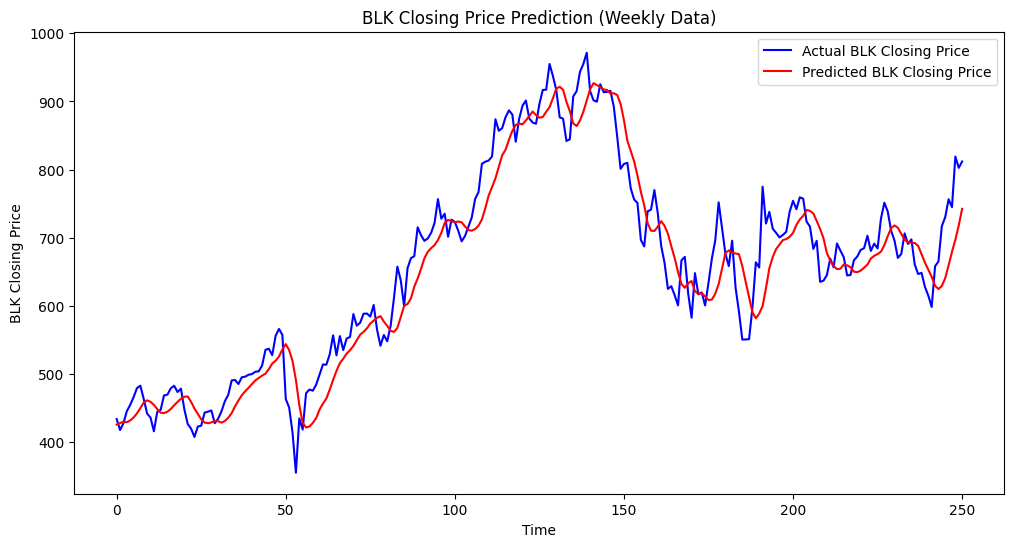

                           Metric  Value
0             Mean Absolute Error  36.59
1         Root Mean Squared Error  45.65
2  Mean Absolute Percentage Error  5.74%
3                        R2 Score   0.90


In [125]:
# Data Loading
data = pd.read_csv('/Users/aliabouyahia/Downloads/Data/BLK-Weekly.csv')

# Check for NaN and infinite values
data.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values with NaN
data.dropna(inplace=True)  # Drop rows with NaN values

# Data Splitting
train = data[0:int(len(data) * 0.80)]
test = data[int(len(data) * 0.80):]

# Features to be used (Open, High, Low)
features = ['Open', 'High', 'Low']

# Scaling the Data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[features])
test_scaled = scaler.transform(test[features])

# Scaling the Close price separately
close_scaler = MinMaxScaler(feature_range=(0, 1))
train_close = close_scaler.fit_transform(train[['Close']])
test_close = close_scaler.transform(test[['Close']])

# Preparing the Training Data
x_train = []
y_train = []

# Here we're using a window size of 100 for sequence creation
for i in range(100, len(train_scaled)):
    x_train.append(train_scaled[i-100:i, :])  # Use 100 days of data for each input
    y_train.append(train_close[i, 0])         # Predict the Close price

x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train to 3D array for LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], len(features)))

# Model Construction
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(x_train.shape[1], len(features))))  # Adjusted input_shape
model.add(Dropout(0.3)) #Droppout allows us to tackle overfitting issues, adjust this value can lead to slightly improved results
model.add(Dense(units=1))

# Model Compilation
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Model Training
model.fit(x_train, y_train, epochs=50, batch_size=32)

# Preparing Testing Data
total_data = pd.concat((train[features], test[features]), axis=0)
inputs = total_data[len(total_data) - len(test) - 100:].values
inputs = scaler.transform(inputs)

x_test = []
Actual_Values = []

for i in range(100, len(inputs)):
    x_test.append(inputs[i-100:i, :])  # Use 100 days of data for each input
    Actual_Values.append(test_close[i-100, 0])  # Predict the Close price

x_test, Actual_Values = np.array(x_test), np.array(Actual_Values)

# Reshaping in 3D array for LSTM model 
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], len(features)))

# Closing Prices forecast
Predicted_Values = model.predict(x_test)

# Inverse scaling the predictions and actual values and plotting 
Predicted_Values = close_scaler.inverse_transform(Predicted_Values)
Actual_Values = close_scaler.inverse_transform(Actual_Values.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(Actual_Values, color='blue', label='Actual BLK Closing Price')
plt.plot(Predicted_Values, color='red', label='Predicted BLK Closing Price')
plt.title('BLK Closing Price Prediction (Weekly Data)')
plt.xlabel('Time')
plt.ylabel('BLK Closing Price')
plt.legend()
plt.show()

# Metrics Evaluation
mae = mean_absolute_error(Actual_Values, Predicted_Values)
mape = mean_absolute_percentage_error(Actual_Values, Predicted_Values)
r2_Score = r2_score(Actual_Values, Predicted_Values)
rmse =np.sqrt(mean_squared_error(Actual_Values,Predicted_Values))

metrics = {
    'Metric': ['Mean Absolute Error', 'Root Mean Squared Error', 'Mean Absolute Percentage Error', 'R2 Score'],
    'Value': [f'{mae:.2f}', f'{rmse:.2f}', f'{(mape*100):.2f}%', f'{r2_Score:.2f}']
}
metrics_Table = pd.DataFrame(metrics)
print(metrics_Table)


Epoch 1/50


/Users/aliabouyahia/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0284 - mean_absolute_error: 0.1085
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0042 - mean_absolute_error: 0.0446
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0036 - mean_absolute_error: 0.0407
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0035 - mean_absolute_error: 0.0387
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0029 - mean_absolute_error: 0.0366
Epoch 6/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0027 - mean_absolute_error: 0.0330
Epoch 7/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0028 - mean_absolute_error: 0.0326
Epoch 8/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0021 - mean_absolute_error: 0.0300
Epoch 9/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0020 - mean_absolute_error: 0.0277
Epoch 10/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0020 - mean_absolute_error: 0.0272
Epoch 11/50
148/148 ━━━━━━━━━━

/Users/aliabouyahia/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


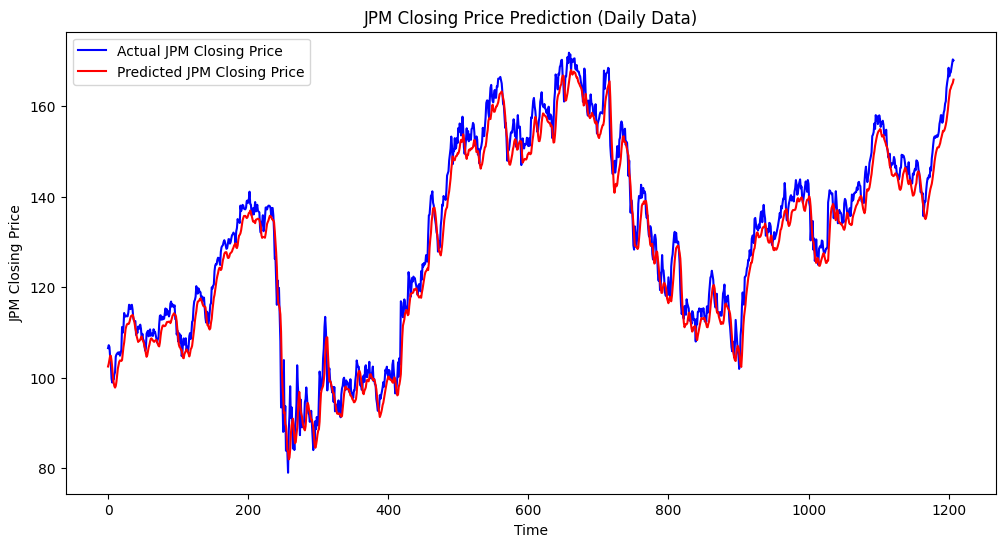

                           Metric  Value
0             Mean Absolute Error   3.22
1         Root Mean Squared Error   3.97
2  Mean Absolute Percentage Error  2.50%
3                        R2 Score   0.97


In [126]:
# Data Loading
data = pd.read_csv('/Users/aliabouyahia/Downloads/Data/JPM-Daily.csv')

# Check for NaN and infinite values : this has been check with and without.It is important to make sure that there is no nan values or division by 0 (represented here by inf) 
# Otherwise the metrics will be wrongly calculated
data.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values with NaN
data.dropna(inplace=True)  # Drop rows with NaN values

# Data Splitting
train = data[0:int(len(data) * 0.80)]
test = data[int(len(data) * 0.80):]

# Features to be used (Open, High, Low)
features = ['Open', 'High', 'Low']

# Scaling the Data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[features])
test_scaled = scaler.transform(test[features])

# Scaling the Close price separately
close_scaler = MinMaxScaler(feature_range=(0, 1))
train_close = close_scaler.fit_transform(train[['Close']])
test_close = close_scaler.transform(test[['Close']])

# Preparing the Training Data
x_train = []
y_train = []

# Here we're using a window size of 100 for sequence creation
for i in range(100, len(train_scaled)):
    x_train.append(train_scaled[i-100:i, :])  # Use 100 days of data for each input
    y_train.append(train_close[i, 0])         # Predict the Close price

x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train to 3D array for LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], len(features)))

# Model Construction
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(x_train.shape[1], len(features))))  # Adjusted input_shape
model.add(Dropout(0.3)) #Droppout allows us to tackle overfitting issues, adjust this value can lead to slightly improved results
model.add(Dense(units=1))

# Model Compilation
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Model Training
model.fit(x_train, y_train, epochs=50, batch_size=32)

# Preparing Testing Data
total_data = pd.concat((train[features], test[features]), axis=0)
inputs = total_data[len(total_data) - len(test) - 100:].values
inputs = scaler.transform(inputs)

x_test = []
Actual_Values = []

for i in range(100, len(inputs)):
    x_test.append(inputs[i-100:i, :])  # Use 100 days of data for each input
    Actual_Values.append(test_close[i-100, 0])  # Predict the Close price

x_test, Actual_Values = np.array(x_test), np.array(Actual_Values)

# Reshaping in 3D array for LSTM model 
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], len(features)))

# Closing Prices forecast
Predicted_Values = model.predict(x_test)

# Inverse scaling the predictions and actual values and plotting 
Predicted_Values = close_scaler.inverse_transform(Predicted_Values)
Actual_Values = close_scaler.inverse_transform(Actual_Values.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(Actual_Values, color='blue', label='Actual JPM Closing Price')
plt.plot(Predicted_Values, color='red', label='Predicted JPM Closing Price')
plt.title('JPM Closing Price Prediction (Daily Data)')
plt.xlabel('Time')
plt.ylabel('JPM Closing Price')
plt.legend()
plt.show()

# Metrics Evaluation
mae = mean_absolute_error(Actual_Values, Predicted_Values)
mape = mean_absolute_percentage_error(Actual_Values, Predicted_Values)
r2_Score = r2_score(Actual_Values, Predicted_Values)
rmse =np.sqrt(mean_squared_error(Actual_Values,Predicted_Values))

metrics = {
    'Metric': ['Mean Absolute Error', 'Root Mean Squared Error', 'Mean Absolute Percentage Error', 'R2 Score'],
    'Value': [f'{mae:.2f}', f'{rmse:.2f}', f'{(mape*100):.2f}%', f'{r2_Score:.2f}']
}
metrics_Table = pd.DataFrame(metrics)
print(metrics_Table)


Epoch 1/50


/Users/aliabouyahia/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1380 - mean_absolute_error: 0.2897
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0124 - mean_absolute_error: 0.0797
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0091 - mean_absolute_error: 0.0692
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0075 - mean_absolute_error: 0.0628
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0067 - mean_absolute_error: 0.0584
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0062 - mean_absolute_error: 0.0558
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0077 - mean_absolute_error: 0.0598
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0065 - mean_absolute_error: 0.0565
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0049 - mean_absolute_error: 0.0522
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0057 - mean_absolute_error: 0.0524
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/ste

/Users/aliabouyahia/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


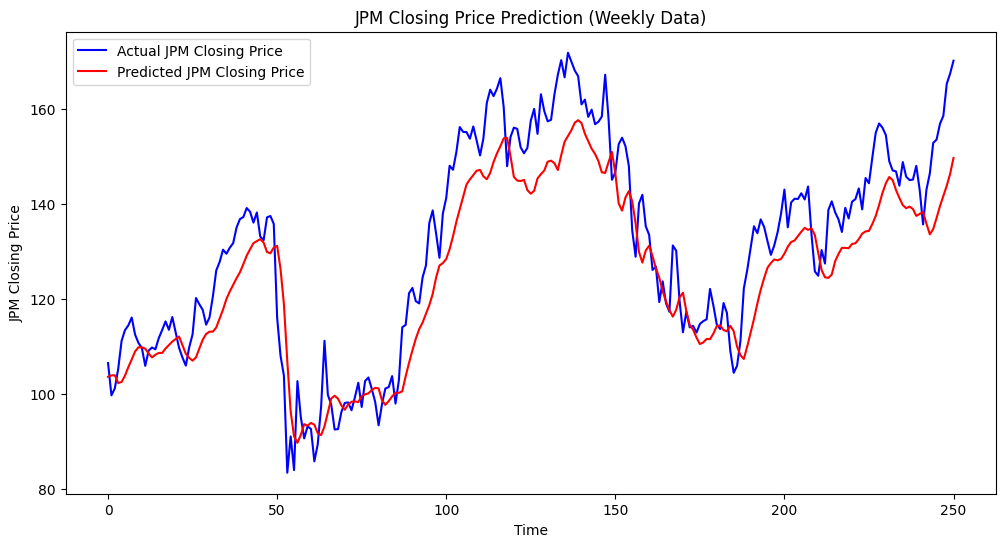

                           Metric  Value
0             Mean Absolute Error   8.04
1         Root Mean Squared Error   9.71
2  Mean Absolute Percentage Error  5.95%
3                        R2 Score   0.80


In [127]:
# Data Loading
data = pd.read_csv('/Users/aliabouyahia/Downloads/Data/JPM-Weekly.csv')

# Check for NaN and infinite values
data.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values with NaN
data.dropna(inplace=True)  # Drop rows with NaN values

# Data Splitting
train = data[0:int(len(data) * 0.80)]
test = data[int(len(data) * 0.80):]

# Features to be used (Open, High, Low)
features = ['Open', 'High', 'Low']

# Scaling the Data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[features])
test_scaled = scaler.transform(test[features])

# Scaling the Close price separately
close_scaler = MinMaxScaler(feature_range=(0, 1))
train_close = close_scaler.fit_transform(train[['Close']])
test_close = close_scaler.transform(test[['Close']])

# Preparing the Training Data
x_train = []
y_train = []

# Here we're using a window size of 100 for sequence creation
for i in range(100, len(train_scaled)):
    x_train.append(train_scaled[i-100:i, :])  # Use 100 days of data for each input
    y_train.append(train_close[i, 0])         # Predict the Close price

x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train to 3D array for LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], len(features)))

# Model Construction
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(x_train.shape[1], len(features))))  # Adjusted input_shape
model.add(Dropout(0.3)) #Droppout allows us to tackle overfitting issues, adjust this value can lead to slightly improved results
model.add(Dense(units=1))

# Model Compilation
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Model Training
model.fit(x_train, y_train, epochs=50, batch_size=32)

# Preparing Testing Data
total_data = pd.concat((train[features], test[features]), axis=0)
inputs = total_data[len(total_data) - len(test) - 100:].values
inputs = scaler.transform(inputs)

x_test = []
Actual_Values = []

for i in range(100, len(inputs)):
    x_test.append(inputs[i-100:i, :])  # Use 100 days of data for each input
    Actual_Values.append(test_close[i-100, 0])  # Predict the Close price

x_test, Actual_Values = np.array(x_test), np.array(Actual_Values)

# Reshaping in 3D array for LSTM model 
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], len(features)))

# Closing Prices forecast
Predicted_Values = model.predict(x_test)

# Inverse scaling the predictions and actual values and plotting 
Predicted_Values = close_scaler.inverse_transform(Predicted_Values)
Actual_Values = close_scaler.inverse_transform(Actual_Values.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(Actual_Values, color='blue', label='Actual JPM Closing Price')
plt.plot(Predicted_Values, color='red', label='Predicted JPM Closing Price')
plt.title('JPM Closing Price Prediction (Weekly Data)')
plt.xlabel('Time')
plt.ylabel('JPM Closing Price')
plt.legend()
plt.show()

# Metrics Evaluation
mae = mean_absolute_error(Actual_Values, Predicted_Values)
mape = mean_absolute_percentage_error(Actual_Values, Predicted_Values)
r2_Score = r2_score(Actual_Values, Predicted_Values)
rmse =np.sqrt(mean_squared_error(Actual_Values,Predicted_Values))

metrics = {
    'Metric': ['Mean Absolute Error', 'Root Mean Squared Error', 'Mean Absolute Percentage Error', 'R2 Score'],
    'Value': [f'{mae:.2f}', f'{rmse:.2f}', f'{(mape*100):.2f}%', f'{r2_Score:.2f}']
}
metrics_Table = pd.DataFrame(metrics)
print(metrics_Table)


Saving the file in HTML is a way to not have to re run the code and see several outputs.This is to facilitate the code consultation while marking
The code below has been extracted online and is only use for file conversion as saving as HTML built in function was causing trouble.

In [129]:
import nbformat
from nbconvert import HTMLExporter

# Load the notebook
with open('/Users/aliabouyahia/Desktop/Code_Final_Project_1737703/Machine Learning Algorithms/LSTM_Stock_Forecast.ipynb','r') as f:
    notebook = nbformat.read(f, as_version=4)

# Convert to HTML
Export_To_HTML = HTMLExporter()
content, resources = Export_To_HTML.from_notebook_node(notebook)

# Write to an HTML file
with open('LSTM.html', 'w') as f:
    f.write(content)